In [2]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [186]:
project_name = 'project_5526'
filelocation='../../capstone_data/Azimuth/clean/{}_featurized.csv'.format(project_name)
df = pd.read_csv(filelocation)
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')
df.set_index('t',inplace=True)

In [187]:
df['power_1'] = df['load_v1rms'] * df['load_i1rms'] 
df['power_2'] = df['load_v2rms'] * df['load_i2rms'] 
df['power_3'] = df['load_v3rms'] * df['laod_i3rms'] 
df['power_all'] = df['power_1'] +df['power_2']+df['power_3']

In [188]:
df2 = df.loc['2017-01-10 00:00:00':]
y = pd.DataFrame(df2['power_all'])

plotting.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['month'] = df.index.month


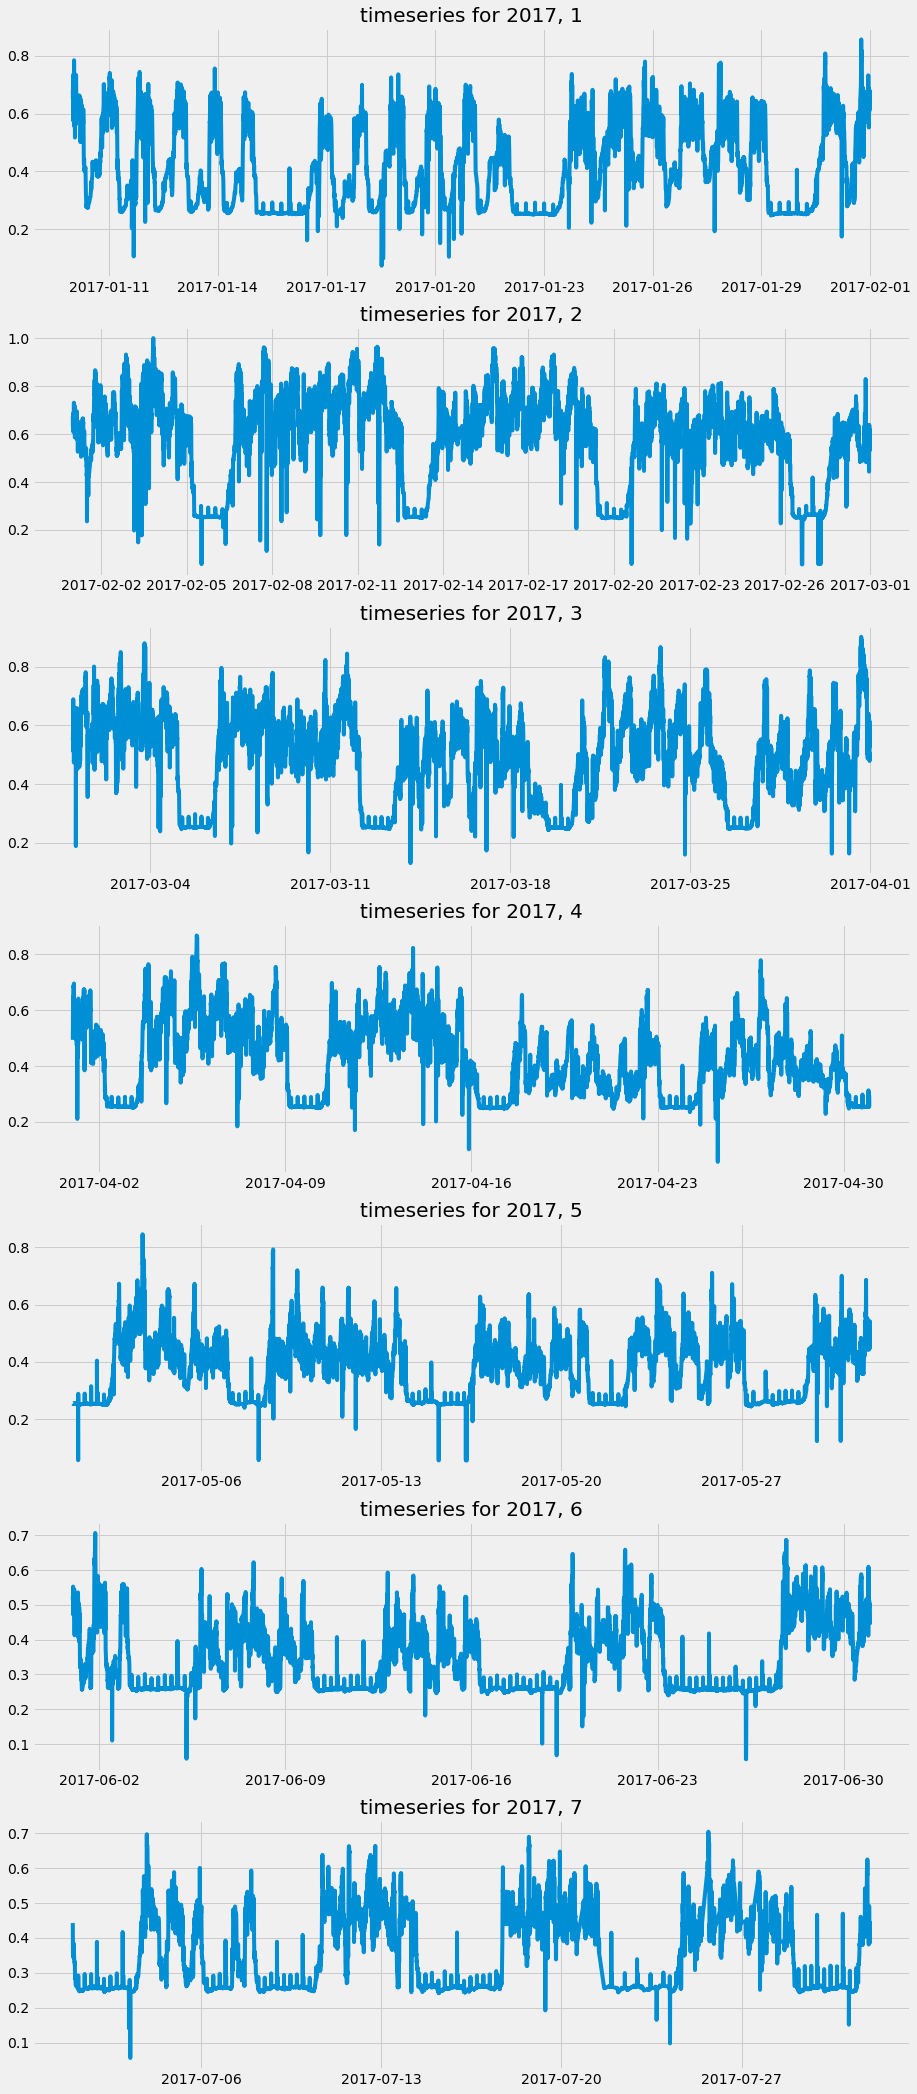

In [5]:
mp.plot_all_data(df2,['power_all'])

In [189]:
y = y['power_all'].resample('H').mean()

In [190]:
y = y.fillna(y.bfill())

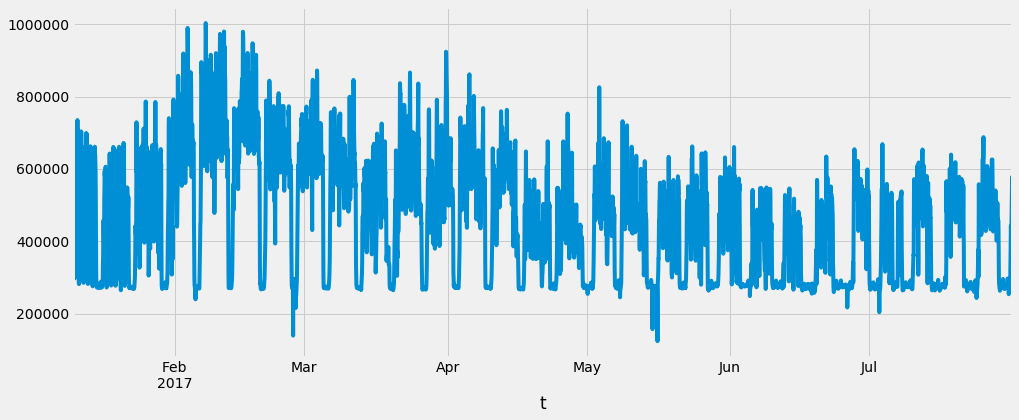

In [8]:
y.plot(figsize=(15, 6))
plt.show()

# Trend Seasonal Residual Decomposition

In [10]:
python_decomposition = sm.tsa.seasonal_decompose(y)
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

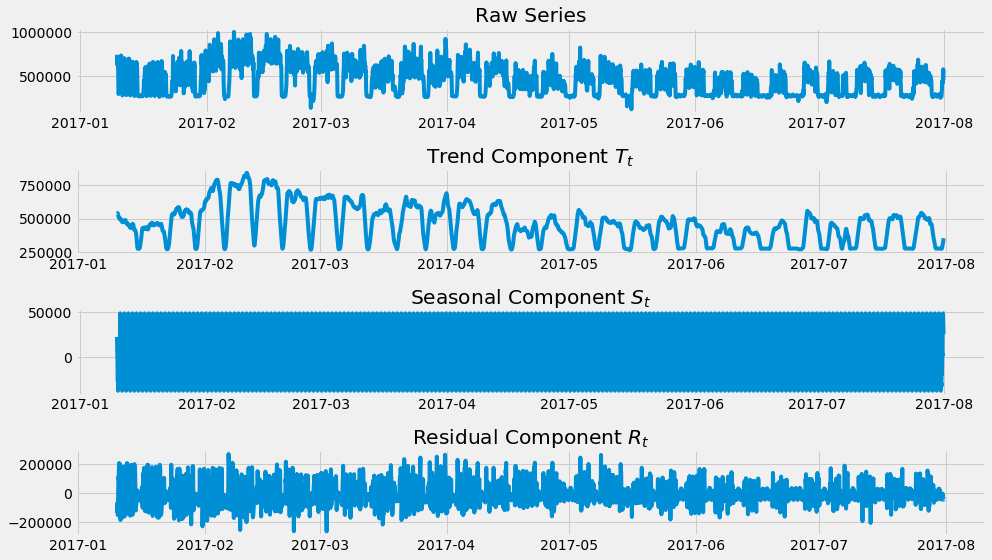

In [11]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, y, python_decomposition)
plt.tight_layout()
plt.show()

## Differencing

In [60]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff(24).diff(168)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

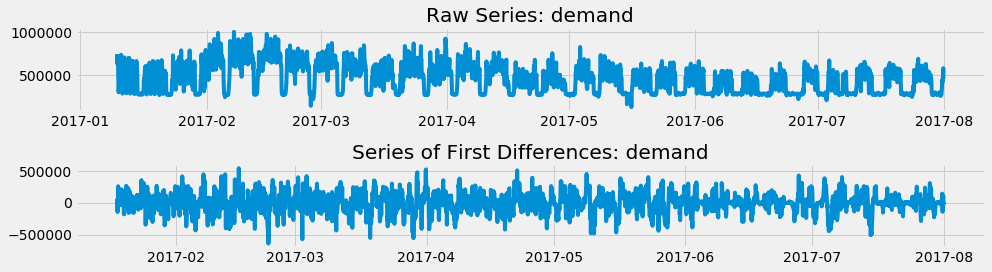

In [61]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, y, 'demand')
fig.tight_layout()
plt.show()

In [24]:
test = sm.tsa.stattools.adfuller(y)
print("ADF p-value for demand series: {0:2.2f}".format(test[1]))

ADF p-value for demand series: 0.00


In [63]:
test = sm.tsa.stattools.adfuller(y.diff(24).diff(168)[(168+240):])
print("ADF p-value for differenced demand series: {0:2.2f}".format(test[1]))

ADF p-value for differenced demand series: 0.00


## Auto correlation plots

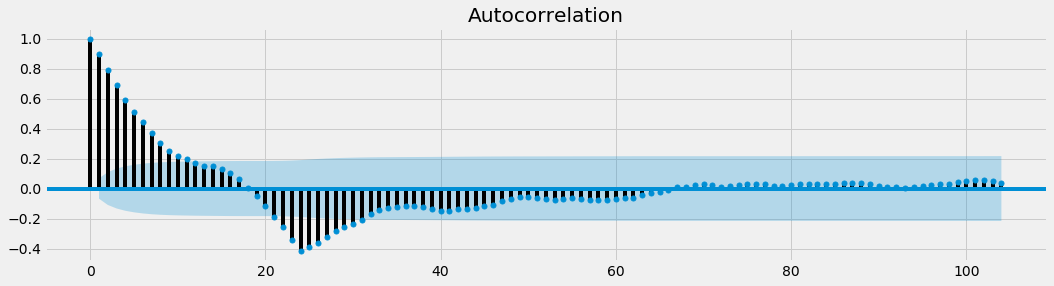

In [78]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(y.diff(24).diff(168)[(24*168):], lags=2*52, ax=ax)

plt.show()

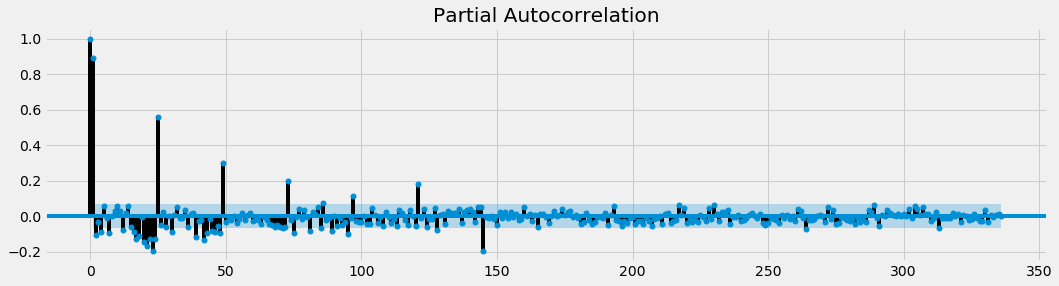

In [140]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(y.diff(24)[24:], lags=14*24, ax=ax)
plt.show()

## Fitting SARIMA

In [191]:
y_diff = y.diff(24)[(24):]
params = (3,0,1)
seasonal_params = (3,0,1,24)
mod = sm.tsa.statespace.SARIMAX(y_diff,order=params,seasonal_order=seasonal_params,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}2016 - AIC:{}'.format(params, seasonal_params, results.aic))

ARIMA(3, 0, 1)x(3, 0, 1, 24)2016 - AIC:117279.419568


In [192]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5704      0.167      9.423      0.000       1.244       1.897
ar.L2         -0.7152      0.161     -4.449      0.000      -1.030      -0.400
ar.L3          0.1193      0.021      5.786      0.000       0.079       0.160
ma.L1         -0.5659      0.168     -3.364      0.001      -0.896      -0.236
ar.S.L24       0.0679      0.023      2.969      0.003       0.023       0.113
ar.S.L48       0.0143      0.022      0.666      0.505      -0.028       0.057
ar.S.L72      -0.0255      0.021     -1.190      0.234      -0.068       0.017
ma.S.L24      -0.9079      0.011    -82.046      0.000      -0.930      -0.886
sigma2      4.139e+09    7.8e-12   5.31e+20      0.000    4.14e+09    4.14e+09


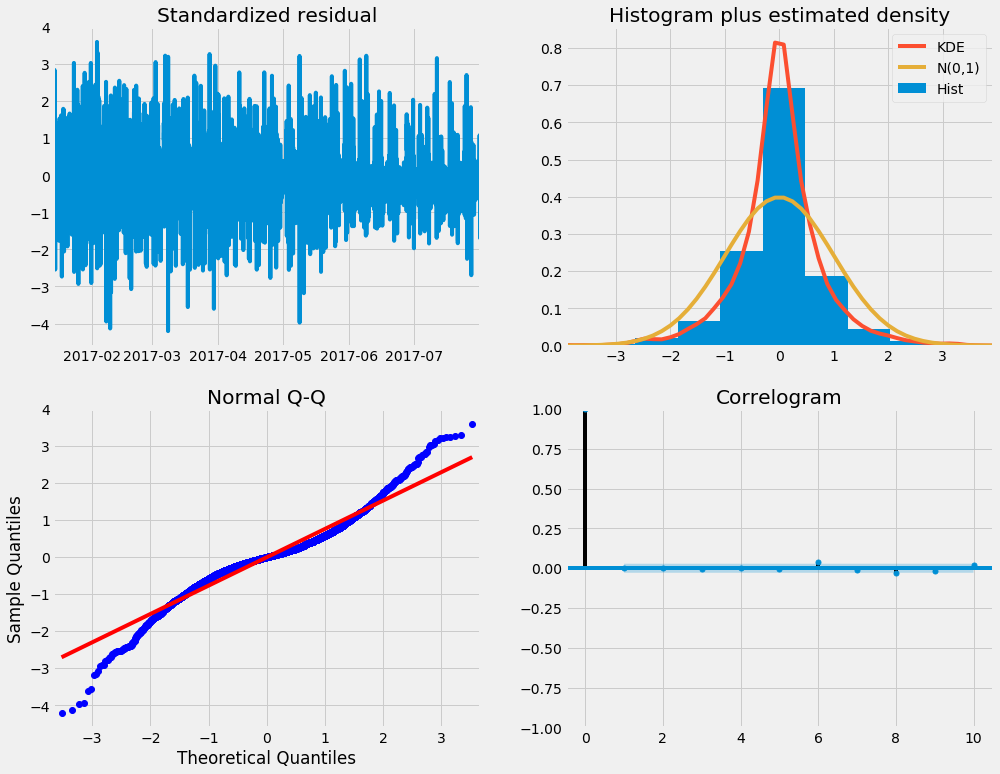

In [193]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [194]:
pred = results.get_prediction(start=pd.to_datetime('2017-07-15'), dynamic=False)
pred_ci = pred.conf_int()

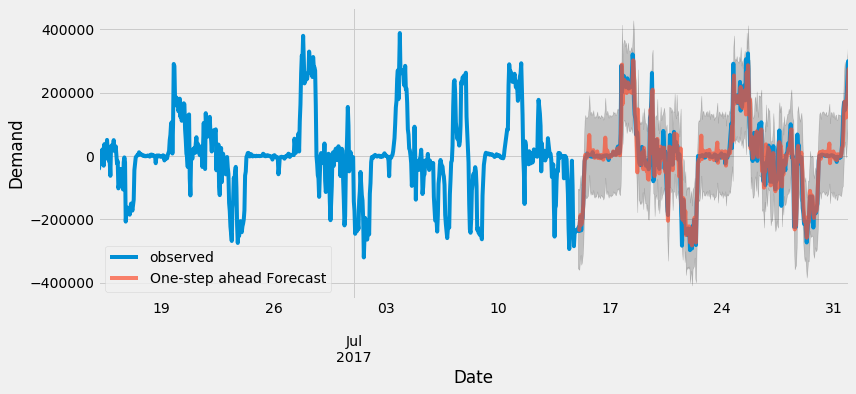

In [195]:

ax = y_diff['2017-06-15 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12,5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [196]:
y_forecasted = pred.predicted_mean
y_truth = y_diff['2017-07-15':]

# Compute the mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 35750.61


In [215]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-07-28'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

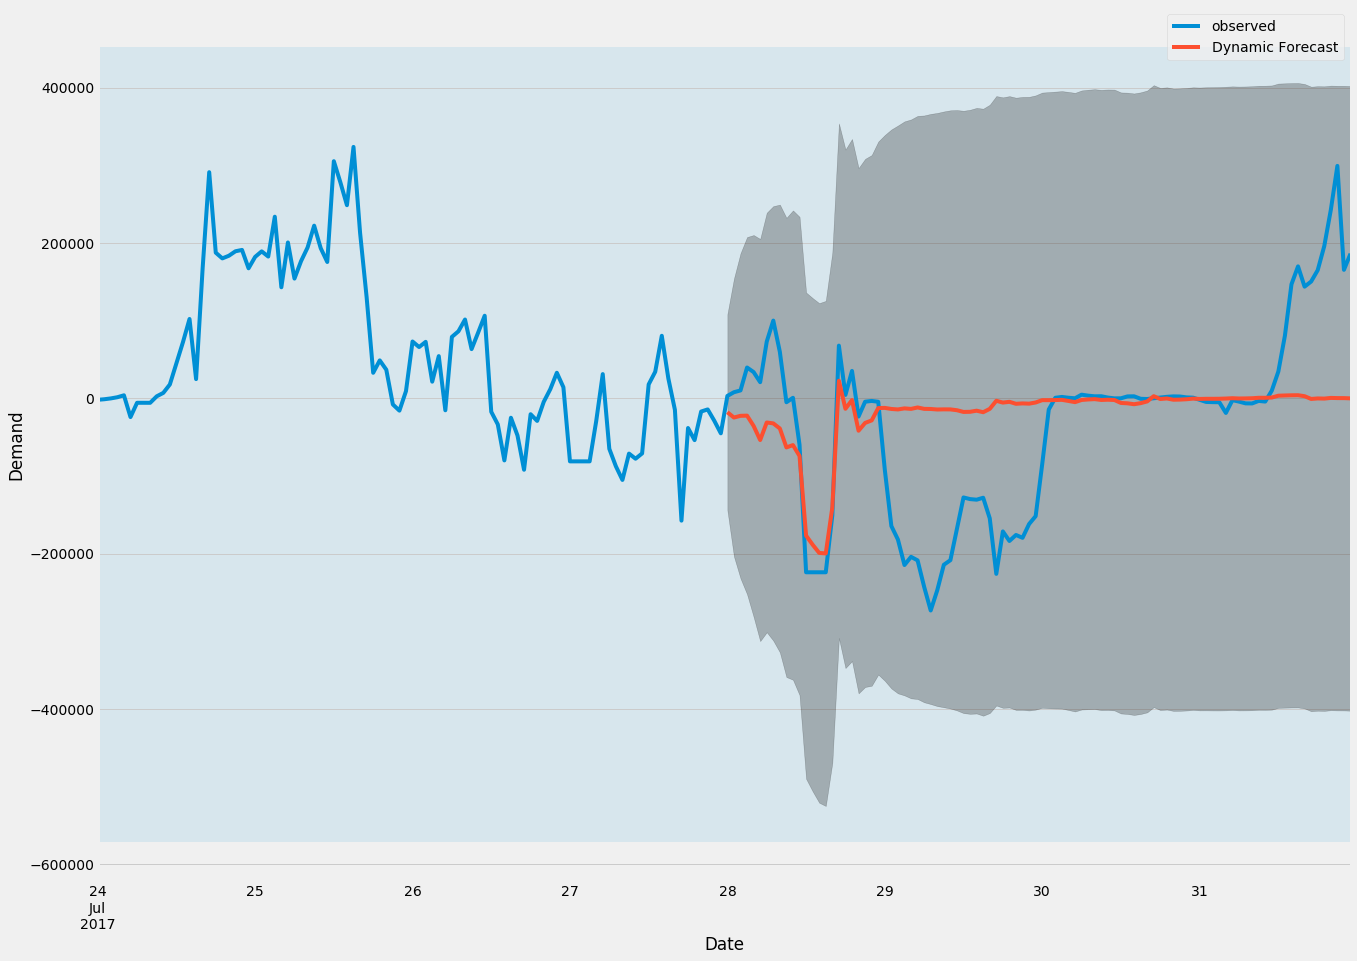

In [216]:
ax = y_diff['2017-07-24 00:00:00':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

### reconstructing the difference.... need a starting week to do so

It worked!!


In [217]:
preds = pred_dynamic.predicted_mean
new_preds = np.zeros(len(preds))
for i in range(len(preds)):
    date = preds.index[i]
#     diff1 = y[date - pd.Timedelta(days=7)]-y[date - pd.Timedelta(days=8)]
    diff2 = y[date - pd.Timedelta(days=1)]
    new_preds[i] = preds.values[i] +  diff2
# y[preds.index[0]-pd.Timedelta(days=1):]
y_true = y[preds.index[0]:].values

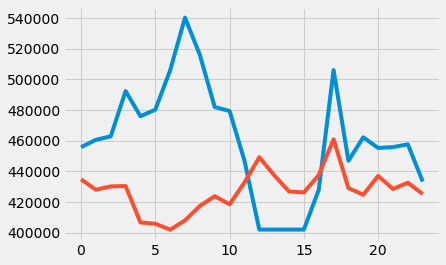

In [218]:
plt.plot(y_true[:24])
plt.plot(new_preds[:24])
plt.show()

## Check that it is working correctly

In [205]:
x = y.diff(24).diff(168)[192:]
new_preds = np.zeros(len(x))
for i in range(len(x)-1):
    date = x.index[i]
    diff1 = y[date - pd.Timedelta(days=7)]-y[date - pd.Timedelta(days=8)]
    diff2 = y[date - pd.Timedelta(days=1)]
    new_preds[i] = x.values[i] + diff1 + diff2
y_true = y[192:].values

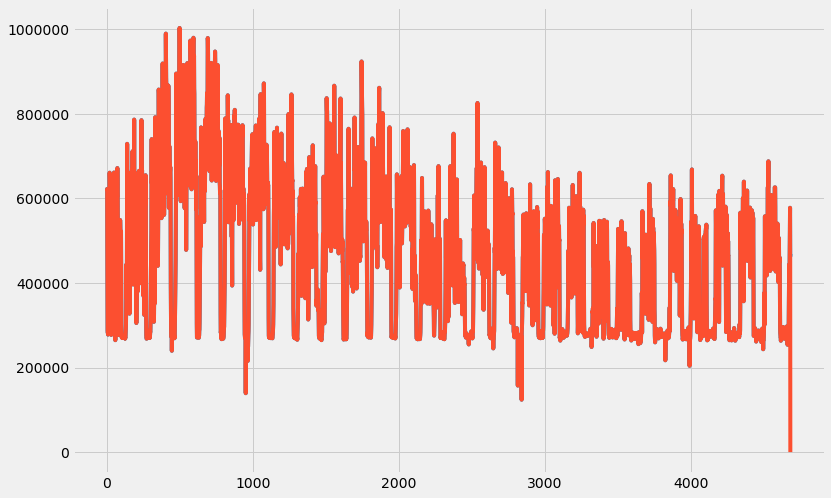

In [206]:
plt.figure(figsize=(12,8))
plt.plot(y_true)
plt.plot(new_preds)
plt.show()

## Create Function

In [219]:
def reconstruct_day_week(preds, y_true):
    new_preds = np.zeros(len(preds))
    for i in range(len(new_preds)):
        date = preds.index[i]
        diff1 = y_true[date - pd.Timedelta(days=7)]-y_true[date - pd.Timedelta(days=8)]
        diff2 = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = preds.values[i] + diff1 + diff2
    return new_preds

def reconstruct_day(preds, y_true):
    new_preds = np.zeros(len(preds))
    for i in range(len(new_preds)):
        date = preds.index[i]
        diff1 = 0
        diff2 = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = preds.values[i] + diff1 + diff2
    return new_preds

In [220]:
preds = pred_dynamic.predicted_mean
new_preds = np.zeros(len(preds))
new_p = reconstruct_day(preds, y)

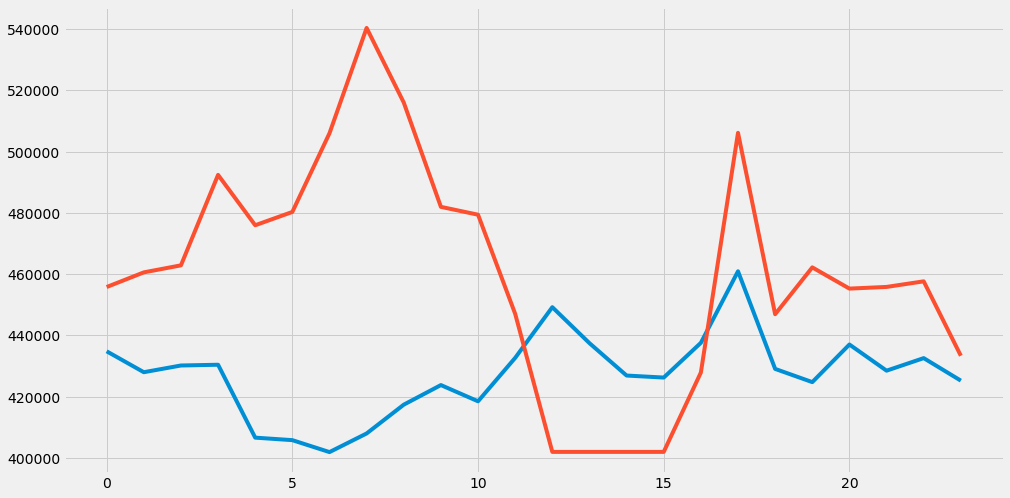

In [221]:
plt.figure(figsize=(15,8))
plt.plot(new_p[:24])
plt.plot(y[preds.index[0]:].values[:24])
plt.show()